# PyTorch - Classification with a CNN - 2
 >__Created__: October 2019, Bari, Italy
 

## Introduction
In this example, we use a convolutional neural network (CNN) to classify the digits in the MNIST data set. Each image is represented by a $(28, 28)$ matrix, with matrix element values in the set $[0, 1/255, \cdots, 1]$. In practice, a __batch__ of images is stored in a 4-index tensor $\mathbf{x}_{ncij}$ of __shape__ $(N, C, H, W)$. Just think of this as a 4-dimensional array each cell of which contains a pixel value. The first index (dim = 0) labels the ordinal value of an image in a batch of $N$ images; the second index (dim = 1) labels the number of __channels__, $C$, which for a gray scale image is $C = 1$, and would be $C = 3$ for a red, green, blue (RGB) image, while the last two indices (dim = 2, 3) label the pixels of an image of height and width $H$ and $W$, respectively. 

### Model

A typical convolutional neural network (CNN) comprises an alternating sequence of convolutional and coarse-graining (or __down-sampling__) layers ending with a fully connected feedforward network. A convolutional layer cross-correlates its inputs with a kernel, while the coarse-graining layer reduces the size of its inputs while (typically) increasing the number of output channels. Here is a high-level view of the model:

\begin{align*}
\mathbf{y} & = \mbox{softmax}(\mathbf{b}_2 + \mathbf{w}_2 {\rm flatten}({\rm relu} ({\rm maxpool} (\mathbf{b}_1 + {\rm cc}(\mathbf{w}_1, \, {\rm relu}({\rm maxpool}(\mathbf{b}_0 + {\rm cc}(\mathbf{w}_0, \, \mathbf{x})))))))),
\end{align*}

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model. The functions are defined as follows:

  * __softmax__ For $K$ output classes, 
\begin{align*}
(\mbox{softmax}(x))_k & = \frac{\exp(x_{(k)})}{\sum_{j=0}^{K-1} \exp(x_{(j)})} ,
\end{align*}
where $x_{(k)}$ denotes the $k^\mbox{th}$ output of the previous layer. The
softmax function
is used to bound the output values to the unit interval and ensure that 
their sum is unity. 

  * __flatten__ Given an input tensor $x$, this function restructures $x$ into a 1-dimensional array.

  * __relu__ Given an input tensor $x$, the following function is applied
*element-wise*, that is, to every element of the tensor,
\begin{align*}
{\rm relu}(x) &= \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

  * __maxpool__ Given an input tensor $x$, this function uses a moveable window to apply a coarse-graining of $x$. In effect, the moveable window  splits the tensor into non-overlapping pieces. Then, for each piece, the maximum value of the original tensor elements associated with that piece is returned. For example, if $x$ is a 2-d tensor, i.e., a matrix, of shape (28, 28), and the window is of shape (2, 2), maxpool splits the original matrix into one with shape (14, 14) and assigns to each of the new matrix elements the maximum value of the associated 4 matrix elements of the original matrix.

  * __cc__ Given two tensors $x$ and $y$, this function returns their cross-correlation.


A high-level view is useful for getting an overview of a model, but it is also good to try to understand the details, at least once. As is often true, a detailed mathematical description of a complicated function 
is made easier using an example. 

#### Convolutional layer
In this example, the data into the first convolutional layer is a single channel (gray scale) image $\mathbf{x}$ of shape $(N, 1, 28, 28)$, which is cross-correlated with a 4-d tensor of weights $\mathbf{w}_0$, with shape $(10, 1, 5, 5)$. We shall refer to the latter as a __kernel__ and each of its $10 \times 1$, $(5, 5)$, matrices (or 2-d tensors) as a __filter__. The first index of the kernel is the number of output channels (10), the second is the number of input channels (1). Therefore, a given $(5, 5)$ filter is identified by two indices: its input and output channel numbers. The last two indices of the kernel are the height (5) and width (5), respectively, of the filters. 

(Unfortunately, the jargon is not consistent across the machine learning literature. What we call a filter is indeed often referred to as a filter, but it is also called a kernel, and what we call a kernel, that is, a stack of one or more filters, often has no specific name attached to it!) 

The operation of the convolutional layer can be written as

\begin{align}
    (\mathbf{b}_0)_k + (\mathbf{w}_0 \otimes \mathbf{x})_{nkij} &= (\mathbf{b}_0)_k + \sum_{c=0}^{C-1} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{nc,\, i+r,\,j+s} \, (\mathbf{w}_0)_{kcrs}, \quad i, j = 0,\cdots, 27.
\end{align}

In the above expression, for a given pixel $i, j$, the filter $k, c$, is cross-correlated with channel $c$ of the input image. Then there is a sum over the input channels, that is, over the index $c$. 

However, for the above computations to work as shown, we need (in effect) to surround each image with extra strips of pixels. This operation is called __padding__. In the following, we choose to pad each image with 2 strips of pixels, with value zero. This padding makes it possible to center the $(5, 5)$ filters on every pixel, $i, j$, within the image. Had we used, for example, $(3, 5)$ filters, the appropriate padding shape would be $(1, 2)$, that is, 1 extra strip of pixels along the top and bottom of the image and 2 extra strips along the left and right sides of the image. But we are free to make other choices.

Since the input image is a $(28, 28)$ matrix padded with 2 strips of pixels around the boundary, and each filter is a $(5, 5)$ matrix,
the output of the convolution step will be a tensor of shape $(N, 10, 28, 28)$ provided that we use a __stride__ of 1, that is, if during the cross-correlation, we shift the filters a horizontal or vertical step of 1 pixel. Other choices are possible. By
construction, the output of this convolutional layer is $N$, 10-channel images, of the same size as the original. 

#### Coarse-graining layer
A convolutional layer is usually followed by a coarse-graining layer that reduces the number of pixels per image. In this example, the number of pixels in the image created by the convolutional layer is reduced by a factor 2 in both directions; that is, each of the 10 channels of the $(28, 28)$ image is coarse-grained, or down-sampled, into a $(14, 14)$ channel by replacing the corresponding group of pixels of shape $(2, 2)$ with a pixel whose value is set to the largest value among the group of 4 pixels.  This operation, called __max-pooling__, can be expressed as

\begin{align}
    {\rm maxpool}(O)_{nkij} &= \max{ \{O_{nk,\, 2i + r,\, 2j + s} \}_{r,\,s = 0, 1} } \quad i, j = 0,\cdots, 13,
\end{align}

where $O$ is the output of a convolutional layer. Again, other choices are possible.

After max-pooling, the output tensor has shape $(N, 10, 14, 14)$. A relu __activation function__ is applied to each element of this tensor in order to complete one sequence of operations: cross-correlation, down-sampling, and activation. 

A second convolutional layer follows. This time, however, its input must match the output of the previous max-pooling operation, which contains $N$ sequences of images, each with 10 channels, and each a $(14, \, 14)$ matrix padded with a 2-pixel boundary. The kernel in this layer contains $16 \times 10$, $(5, 5)$, filters, that is, it is of shape $(16, 10, 5, 5)$. Each of the 160, $(5, 5)$, filters is cross-correlated with the corresponding input channel. The cross-correlated input channels are then summed pixel by pixel to yield  a 16-channel output image from this layer. In other words, we arrive at an output tensor of size $(N, 16, 14, 14)$.

Finally, a second max-pooling layer is applied, which transforms the 16-channel image of shape $(14, 14)$ to a 16-channel image of shape $(7, 7)$. The image is then flattened into a 1-d tensor (basically, a 1-d array) of size $16 \times 7 \times 7 = 784$, which are the inputs of the final linear layer with 10 outputs. Finally, a softmax function is applied.

### Loss function

See description in pytorch\_exercise\_1. 


In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

import imageio as im
import torch
import torch.nn as nn
import torch.nn.functional as F

#  a function to save results
try:
    from joblib import joblib
except:
    from sklearn.externals import joblib

from torch.autograd import Variable

%matplotlib inline

/Users/harry/miniconda2/envs/python3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
seed = 128
rnd  = np.random.RandomState(seed)

### Load Images

In [3]:
train_x, train_y = joblib.load('../datasets/mnist_train.pkl')
test_x,  test_y  = joblib.load('../datasets/mnist_test.pkl')

### Plot first few  images
Use imshow(..) and show() to display the image.

In [4]:
def plotImages(x, n_rows=2, n_cols=5, f_size=(10, 4)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

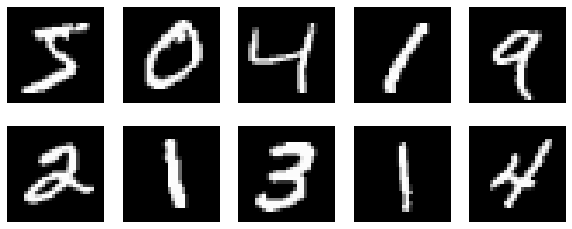

In [5]:
plotImages(train_x)

### Prepare training and validation sets

In [6]:
n_iter   = 10000
n_batch  = 128
learning_rate = 1.e-3
train_fraction = 0.7

In [7]:
M = int(train_fraction*len(train_x))
train_x, val_x = train_x[:M], train_x[M:]
train_y, val_y = train_y[:M], train_y[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)
n_valid_b = 5000

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("validation batch size:           %10d" % n_valid_b)
print("number of images for testing:    %10d" % n_test)

x = torch.tensor(train_x[0].reshape(1, 1, 28, 28))

number of images for training:        42000
number of images for validation:      18000
validation batch size:                 5000
number of images for testing:         10000


### Model

In [8]:
%%writefile CNN.py

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):

        """
    A convolutional + fully-connected linear network.
        """ 
        # call constructor of base (or super, or parent) class
        super(CNN, self).__init__()
        
        # adding a padding of 2 will allow cross-correlation of the 
        # entire input image with the 10 filters. that way, we
        # obtain output images that are the same size as the
        # input images.
        self.conv0 = nn.Conv2d(in_channels=1, 
                               out_channels=10, 
                               kernel_size=5,
                               stride=1,
                               padding=2)
        
        self.conv1 = nn.Conv2d(in_channels=10, 
                               out_channels=16, 
                               kernel_size=5,
                               stride=1,
                               padding=2)
        
        # we end with a linear layer. we need to compute the number
        # of inputs to that layer. Ignoring the first index of the output
        # tensor from conv1, which simply labels the ordinal value of 
        # the image in the batch of images, we note the following:
        # 1. conv0 outputs a tensor of size (10, 28, 28).
        #    we then coarse-grain to a tensor of size (10, 14, 14)
        # 2. conv1 outputs a tensor of size (16, 14, 14), which is
        #    coarse-grained to one of size (16, 7, 7)
        # 3. therefore, when flattened, the number of inputs is
        #    16 * 7 * 7 = 784
        self.n_inputs = 16 * 7 * 7
        #    and we have 10 outputs, one for each digit
        self.linear0 = nn.Linear(self.n_inputs, 10)
        
    def __str__(self):
        s = ''
        for layer in [self.conv0, 
                      self.conv1,
                      self.linear0]:
            s += '%s\n' % layer
        return s
    
    # define (required) method to compute output of network
    def forward(self, x):
        """
        x:  input data (of type Variable) 
        """
        # conv0 expects 4-d tensor, so reshape accordingly
        # the -1 means the size is given by x
        y = x.view(-1, 1, 28, 28)
        
        # 1. cross-correlate the input tensor of shape (-1, 1, 28, 28),
        #    padded with a 2-pixel wide strip, with a (10, 5, 5) kernel,
        #    thereby producing an output tensor os shape (-1, 10, 28, 28)
        # 2. coarse-grain with a (2,2) window, which shifts horizontally
        #    and vertically 2 pixels at a time. This replaces the 10,
        #    28x28 channels by 10 14x14 channels by replacing a group of
        #    4 pixels with one. The output tensor at this stage has shape
        #    (-1, 10, 14, 14).
        # 3. apply a relu function to every element of the tensor
        y = F.relu(F.max_pool2d(self.conv0(y), 2))
        
        # 1. cross-correlate a (-1, 10, 14, 14) tensor, padded as above, 
        #    with a (16, 5, 5) kernel and, for each (5, 5) filter, sum 
        #    over the 10 input channels. Since the kernel contains 16 
        #    filters, the end result is a 16-channel image. The output 
        #    therefore has shape (-1, 16, 14, 14).
        # 2. coarse-grain with a (2,2) window, as above, thereby creating
        #    an output tensor of shape (-1, 16, 7, 7).
        # 3. apply a relu function element-wise (as above).
        y = F.relu(F.max_pool2d(self.conv1(y), 2))
       
        # flatten the tensor (-1, 16, 7, 7) to the tensor (-1, 16*7*7).
        y = y.view(-1, self.n_inputs)
        
        # during training (only), randomly dropout, that is, zero, 
        # half of the elements in the current tensor y. dropout has
        # been shown to improve the training and yield better results.
        # dropout effectively deactivates all the weights attached 
        # to the zeroed element. alternatively, it can be thought of as a
        # way to apply random modifications to a multi-channel image by
        # randomly setting half the pixels to zero at each iteration.
        y = F.dropout(y, p=0.5, training=self.training)
    
        # apply a linear transformation to the (-1, 784) tensor.
        y = self.linear0(y)
        
        # apply the softmax function horizontally, i.e., along 
        # the class axis (dim=1) in order to ensure that the outputs sum
        # to unity.
        # (Note: dim=0 is vertical, that is, along the batch axis.)
        
        # final output: estimated class probabilities for ith image,
        #   q_i(k) = exp(y_i(k) / sum_j exp(y_i(j)), j = 0,..., K-1,
        # where K=10 is the number of classes and y_i(k) is the output 
        # for the ith feature vector for class index k. 
        
        y = F.softmax(y, dim=1)

        return y

Writing CNN.py


### Create an instance of the model

In [9]:
from CNN import CNN
model = CNN()
model

CNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (linear0): Linear(in_features=784, out_features=10, bias=True)
)

### Define loss function

In [10]:
class MyCrossEntropyLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
        outputs:  shape (batch_size, number_classes), pre-softmax outputs
        targets:  shape (batch_size, ), class indices [0,...,C-1] 
        """
        batch_size = len(outputs)
        
        # ---------------------------------------------------------------      
        # Estimated class probability for ith feature vector
        #   q_i = exp(x_i(m) / sum_n exp(x_i(n)), n = 0,..., C-1,
        # where C is the number of classes and x_i(n) is the raw output 
        # for the ith feature vector whose class index is n. 
        # The cross entropy is defined by
        #   H(p, q) = -sum_i p_i log(q_i)
        #
        # The entropy is defined by
        #   H(p)    = -sum_i p_i log(p_i)
        # and the Kullback-Leibler divergence by
        #   D(p||q) = -sum_i p_i log(p_i/q_i)
        #           = -sum_i p_i log(p_i) + sum_i p_i log(q_i)
        #           = H(p) - H(p, q)
        # Therefore, the cross entropy is minimized when the estimated 
        # probabilities q_i match the true probabilities p_i, in which 
        # case the cross entropy equals the entropy.
        # --------------------------------------------------------------- 
        
        # Note the numpy-like syntax for accessing elements of the
        # tensor: outputs[list1, list2] 
        # Note also: range(batch_size) is [0,...batch_size-1]
        #
        # pick the output values corresponding to the targets, which, 
        # recall, is a 1-d tensor (basically, a 1-d array) of class labels 
        outputs = outputs[range(batch_size), targets]
        return -torch.sum(torch.log(outputs)) / batch_size

In [11]:
loss_fn = MyCrossEntropyLoss()

### Get batch
Get a random sample from the training set of size $batch\_size$

In [12]:
def randomBatch(train_x, train_y, batch_size):
    rows    = rnd.choice(len(train_x), batch_size)
    batch_x = train_x[rows]
    batch_y = train_y[rows]
    return (batch_x, batch_y)

### Accuracy
Fraction of correct predictions

In [13]:
def accuracy(outputs, targets):
    # For each feature vector, return predicted class label using argmax.
    #
    # argmax scans the numpy along the specified axis, here the 
    # horizontal axis, which is in the class direction, and returns the
    # ordinal value of the maximum value. 
    outputs = np.argmax(outputs.data.numpy(), axis=1)
    
    return float(np.sum(outputs==targets.data.numpy())) / len(targets)

### Trainer

In [14]:
def train(model, optimizer, loss_fn, train_x, train_y, batch_size):
    model.train() # training mode
    batch_x, batch_y = randomBatch(train_x, train_y, batch_size)

    with torch.no_grad():  # no need to compute gradients wrt. to x, y
        x = Variable(torch.from_numpy(batch_x))
        y = Variable(torch.from_numpy(batch_y))       
    
    outputs = model(x)
    
    loss    = loss_fn(outputs, y)        
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    optimizer.step()       # move one step
        
def validate(model, train_x, train_y, val_x, val_y):
    model.eval() # evaluation mode
    with torch.no_grad():  # no need to compute gradients wrt. to x, y
        
        # to speed things up, use a random subset of n_valid_b images.
        batch_x, batch_y = randomBatch(train_x, train_y, n_valid_b)
        x = Variable(torch.from_numpy(batch_x))
        y = Variable(torch.from_numpy(batch_y))       
        o = model(x)
        acc_t = accuracy(o, y)
          
        batch_x, batch_y = randomBatch(val_x, val_y, n_valid_b)  
        x = Variable(torch.from_numpy(batch_x))
        y = Variable(torch.from_numpy(batch_y))      
        o = model(x)
        acc_v = accuracy(o, y)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, loss_fn, 
               train_x, train_y,
               val_x, val_y,
               n_iterations, batch_size):
    xx   = []
    yy_t = []
    yy_v = []

    for ii in range(n_iterations):
        train(model, optimizer, loss_fn, 
              train_x, train_y, 
              batch_size)

        if ii < 20:
            step = 1
        elif ii < 100:
            step = 10
        elif ii < 1000:
            step = 100
        else:
            step = 500
        
        if ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_y, 
                                    val_x, val_y)
            
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

### Choose minimizer

In [15]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

### Train and validate

In [ ]:
xx, yy_t, yy_v = trainModel(model, optimizer, loss_fn,
                            train_x, train_y, 
                            val_x,   val_y,
                            n_iter,  n_batch)
print("done!")

         0	    0.1254	    0.1300
         1	    0.1336	    0.1364
         2	    0.1354	    0.1290
         3	    0.1414	    0.1424
         4	    0.1660	    0.1630
         5	    0.2122	    0.2058
         6	    0.3018	    0.2936
         7	    0.4418	    0.4430
         8	    0.5244	    0.5300
         9	    0.5680	    0.5680
        10	    0.5640	    0.5760
        11	    0.5554	    0.5856
        12	    0.5526	    0.5782
        13	    0.5510	    0.5704
        14	    0.5388	    0.5584
        15	    0.5502	    0.5558
        16	    0.5750	    0.5910
        17	    0.6010	    0.6260
        18	    0.5980	    0.6042
        19	    0.6398	    0.6568
        20	    0.6798	    0.7006
        30	    0.7160	    0.7270
        40	    0.7704	    0.7804
        50	    0.8104	    0.8214
        60	    0.8516	    0.8566
        70	    0.8684	    0.8696
        80	    0.8834	    0.8816
        90	    0.8818	    0.8890
       100	    0.8886	    0.8864
       200	    0.9438	    0.9400
       300

In [32]:
def plot(xx, yy_t, yy_v):
    # Note: every element in a plot is an Artist object! 
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    # adjust y limits
    axes = ax.axes
    axes.set_ylim((0.8, 1))
    axes.set_xlim((0, xx[-1]))
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')
    plt.title('Training and Validation Errors')
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, which="both", linestyle='-')
    plt.legend(loc='lower right')
    plt.show()

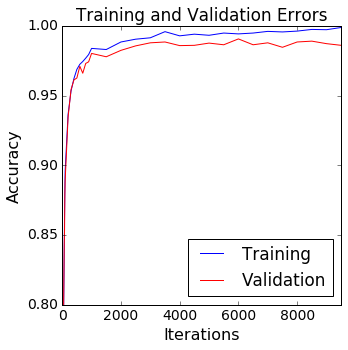

In [33]:
plot(xx, yy_t, yy_v)

### Save model state

In [34]:
print("model details")
for key in model.state_dict():
    print('  %-16s\t%s' % (key, model.state_dict()[key].size()))

model details
  conv0.weight    	torch.Size([10, 1, 5, 5])
  conv0.bias      	torch.Size([10])
  conv1.weight    	torch.Size([16, 10, 5, 5])
  conv1.bias      	torch.Size([16])
  linear0.weight  	torch.Size([10, 784])
  linear0.bias    	torch.Size([10])


In [35]:
torch.save(model.state_dict(), 'mnist_model_cnn.pth')